This document wants to train a neural network, to predict the baseline power output for a simple farm, with given wind directions.

In [5]:
# Importing stuff
import numpy as np
from floris.tools import FlorisInterface
import matplotlib.pyplot as plt
import os
import time

In [6]:
# Creating the farm:
dist = 5
nx = 3
ny = 3
turb_type = 'nrel_5MW'
combination = 'sosfs'
deflection = 'gauss'
turbulence = 'crespo_hernandez'
velocity = 'gauss'
WS_min = 4
WS_max = 20
TI_min = 0.01
TI_max = 0.15
wd_min = 270
wd_max = 360
yaw_max = 25
rho = 1.225
seed = 0

In [7]:
fi = FlorisInterface("gch.yaml")   
        
#Turns it into a dictionary and then does the changes to the model
fi_dict = fi.floris.as_dict()

fi_dict["farm"]["turbine_type"] = [turb_type]
fi_dict["wake"]["model_strings"]["combination_model"] = combination
fi_dict["wake"]["model_strings"]["deflection_model"]  = deflection
fi_dict["wake"]["model_strings"]["turbulence_model"]  = turbulence
fi_dict["wake"]["model_strings"]["velocity_model"]    = velocity
fi_dict["flow_field"]["air_density"]                  = rho

# Turns it back into a floris object:
fi = FlorisInterface(fi_dict)

D = fi.floris.farm.rotor_diameters[0]

x = np.linspace(0, D*dist*nx, nx)
y = np.linspace(0, D*dist*ny, ny)

xv, yv = np.meshgrid(x, y, indexing='xy')

layout_x =  xv.flatten()
layout_y = yv.flatten()

In [8]:
n_wind_dir = 50

In [9]:
wd = np.linspace(270, 315, num = n_wind_dir)

In [10]:
TI = 0.07
ws = 7
fi.reinitialize(
    layout=(layout_x, layout_y),
    wind_directions=wd,
    turbulence_intensity= TI,
    wind_speeds=[ws]
    )

In [11]:
fi.calculate_wake()

In [12]:
farm_power = fi.get_farm_power()

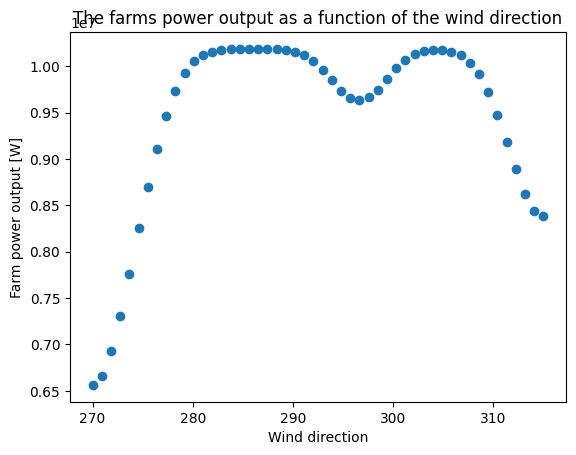

In [13]:
plt.scatter(wd, farm_power)
plt.xlabel("Wind direction")
plt.ylabel("Farm power output [W]")
plt.title("The farms power output as a function of the wind direction")
plt.show()

In [14]:
# Importing machine larning stuff
from sklearn.model_selection import train_test_split
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks 
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [15]:
X_data = wd
y_data = farm_power
len(X_data), len(y_data)

(50, 50)

In [16]:
seed = 1

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=seed, shuffle=True)
X_train, X_val, y_train, y_val   = train_test_split(X_train, y_train, test_size=0.25, random_state=seed) # 0.25 x 0.8 = 0.2

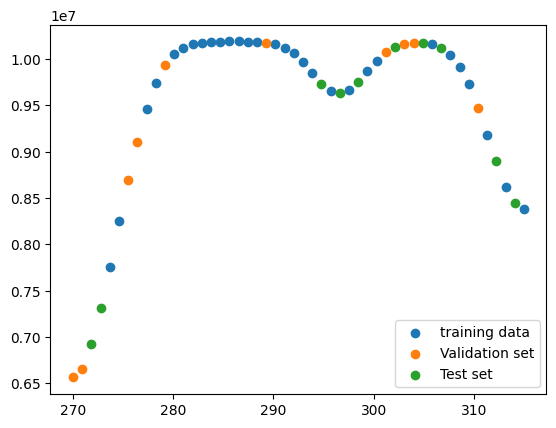

In [84]:
plt.scatter(X_train,y_train, label="training data")
plt.scatter(X_val, y_val, label="Validation set")
plt.scatter(X_test, y_test, label ="Test set")

plt.legend()
plt.show()


In [104]:
class Baseline_Power(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    """Initializes multi-class classification model.
    
    Args:
      input_features (int): Number of input features to the model
      output_features (int): Number of outputs features (number of output classes)
      hidden_units (int): Number of hidden units between layers, default 8

    Returns:

    Example:
    """
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.Sigmoid(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.Sigmoid(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.Sigmoid(),
        nn.Linear(in_features=hidden_units, out_features=output_features)
    )

  def forward(self, x):
    return self.linear_layer_stack(x)

# Create an instance of BlobModel and send it to the target device
model_1 = Baseline_Power(input_features=1,
                    output_features=1,
                    hidden_units=1024).to(device)

model_1

Baseline_Power(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=1, out_features=1024, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=1024, out_features=1024, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=1024, out_features=1024, bias=True)
    (5): Sigmoid()
    (6): Linear(in_features=1024, out_features=1, bias=True)
  )
)

In [105]:
# Setup a loss function
loss_fn = nn.L1Loss()

# Setup an optimizer (stochastic gradient descent)
optimizer = torch.optim.SGD(params=model_1.parameters(), # we want to optimize the parameters present in our model
                            lr=0.01) # lr = learning rate = possibly the most important hyperparameter you can set



In [87]:
X_train = torch.from_numpy(X_train).float().to(device)
y_train = torch.from_numpy(y_train).float().to(device)/1000000
X_test = torch.from_numpy(X_test).float().to(device)
y_test = torch.from_numpy(y_test).float().to(device)/1000000

X_train = torch.unsqueeze(X_train, dim=1)
X_test = torch.unsqueeze(X_test, dim=1)
X_train.size()

torch.Size([30, 1])

In [106]:
torch.manual_seed(seed)

# An epoch is one loop through the data... (this is a hyperparameter because we've set it ourselves)
epochs = 1_000

# Track different values
epoch_count = [] 
loss_values = []
test_loss_values = [] 

### Training
# 0. Loop through the data
for epoch in range(epochs): 
  # Set the model to training mode
  model_1.train() # train mode in PyTorch sets all parameters that require gradients to require gradients 

  # 1. Forward pass
  y_pred = model_1(X_train)

  # 2. Calculate the loss
  loss = loss_fn(y_pred, y_train)

  # 3. Optimizer zero grad
  optimizer.zero_grad() 

  # 4. Perform backpropagation on the loss with respect to the parameters of the model (calculate gradients of each parameter)
  loss.backward()

  # 5. Step the optimizer (perform gradient descent)
  optimizer.step() # by default how the optimizer changes will acculumate through the loop so... we have to zero them above in step 3 for the next iteration of the loop

  ### Testing
  model_1.eval() # turns off different settings in the model not needed for evaluation/testing (dropout/batch norm layers)
  with torch.inference_mode(): # turns off gradient tracking & a couple more things behind the scenes - https://twitter.com/PyTorch/status/1437838231505096708?s=20&t=aftDZicoiUGiklEP179x7A
  # with torch.no_grad(): # you may also see torch.no_grad() in older PyTorch code
    # 1. Do the forward pass 
    test_pred = model_1(X_test)

    # 2. Calculate the loss
    test_loss = loss_fn(test_pred, y_test)

  # Print out what's happenin'
  if epoch % 100 == 0:
    epoch_count.append(epoch)
    loss_values.append(loss)
    test_loss_values.append(test_loss)
    print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")
    # Print out model state_dict()
    # print(model_1.state_dict())

Epoch: 0 | Loss: 9.613465309143066 | Test loss: 6.308657169342041
Epoch: 100 | Loss: 1.3034833669662476 | Test loss: 1.1458208560943604
Epoch: 200 | Loss: 0.4041863977909088 | Test loss: 0.9833723306655884
Epoch: 300 | Loss: 0.40418580174446106 | Test loss: 0.9833879470825195
Epoch: 400 | Loss: 0.40418532490730286 | Test loss: 0.9834070205688477
Epoch: 500 | Loss: 0.40418487787246704 | Test loss: 0.9834287762641907
Epoch: 600 | Loss: 0.4041844606399536 | Test loss: 0.9834526181221008
Epoch: 700 | Loss: 0.40418389439582825 | Test loss: 0.9834791421890259
Epoch: 800 | Loss: 0.404183566570282 | Test loss: 0.9835075736045837
Epoch: 900 | Loss: 0.4041830897331238 | Test loss: 0.9835392236709595


In [107]:
model_1.eval() # turns off different settings in the model not needed for evaluation/testing (dropout/batch norm layers)
with torch.inference_mode(): # turns off gradient tracking & a couple more things behind the scenes - https://twitter.com/PyTorch/status/1437838231505096708?s=20&t=aftDZicoiUGiklEP179x7A

    y_pred = model_1(X_train)

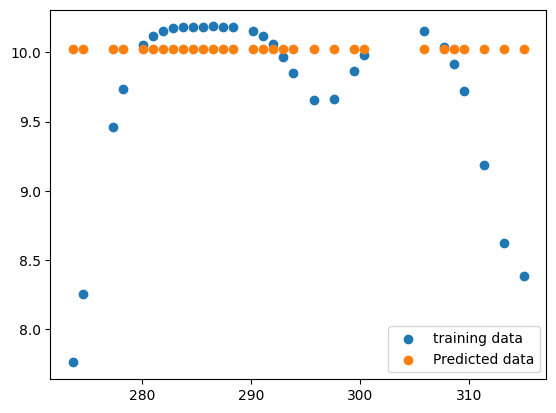

In [108]:
plt.scatter(X_train.cpu(), y_train.cpu(), label="training data")
plt.scatter(X_train.cpu(), y_pred.cpu(), label="Predicted data")

plt.legend()
plt.show()